# **Neural Networks DSM150-2022-OCT**
## **Course Work 2** : Neural networks application for Computer vision

### **Title** : Satellite Image - Image Segmentation [Building]

### Introduction
object detection in satellite imagery has exciting application, one of the many use cases involves detecting buildings for Network planning purposes in telecommunications deployement scenario. 
For the project the objective is to train a Neural network over satelite imagery available freely from Spacenet.ai. A Semantic segmentation technique will be used as the output of the model. 

### Data Source  
Data is available from Spacenet.ai as an AWS resource [https://spacenet.ai/rio-de-janeiro/]. The dataset contains 6,940 (400*400 pixel) setallite images of Rio de Jeneiro [3.45 GB] acompanied by its vector data in Geojson format [93 MB]
Following calls will download the required data sets:
  
  
aws s3 cp s3://spacenet-dataset/AOIs/AOI_1_Rio/processedData/processedBuildingLabels.tar.gz .
aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz .  
aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz   
aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz .  

### Important References:  
https://github.com/adil-py/spacenet_building_detection  
https://medium.com/the-downlinq/getting-started-with-spacenet-data-827fd2ec9f53    
Deep Learning with Python 2nd Edition (Francois Chollet)


Defining the working directories

In [19]:
import os
from tqdm import tqdm
currentpath = os.getcwd()
lev2up = os.path.dirname(os.path.dirname(currentpath))
datadir = os.path.join(lev2up,"data")
rasterdir = os.path.join(datadir,"3band")
vectordir = os.path.join(datadir,"processedBuildingLabels\\vectordata\\geojson")
destdir = os.path.join(datadir,"buildingMaskImages")
splitdir = os.path.join(datadir,"dataSplit")
maskdir = os.path.join(datadir,"buildingMaskImages")
print(vectordir)

c:\Users\toadi\Documents\GitHub\spacenet_building_detection\data\processedBuildingLabels\vectordata\geojson


Function for Converting the Vector data for each image into its corresponding Mask image

In [20]:
# Add create_poly_mask

# Reference: 
# https://medium.com/the-downlinq/getting-started-with-spacenet-data-827fd2ec9f53
# https://gist.github.com/avanetten/b295e89f6fa9654c9e9e480bdb2e4d60#file-create_building_mask-py

from osgeo import gdal, ogr
from PIL import Image
import numpy as np
import random


def create_poly_mask(rasterSrc, vectorSrc, npDistFileName='', 
							noDataValue=0, burn_values=1):

	'''
	Create polygon mask for rasterSrc,
	Similar to labeltools/createNPPixArray() in spacenet utilities
	'''
	
	## open source vector file that truth data
	source_ds = ogr.Open(vectorSrc)
	source_layer = source_ds.GetLayer()

	## extract data from src Raster File to be emulated
	## open raster file that is to be emulated
	srcRas_ds = gdal.Open(rasterSrc)
	cols = srcRas_ds.RasterXSize
	rows = srcRas_ds.RasterYSize

	if npDistFileName == '':
		dstPath = ".tmp.tiff"
	else:
		dstPath = npDistFileName

	## create First raster memory layer, units are pixels
	# Change output to geotiff instead of memory 
	memdrv = gdal.GetDriverByName('GTiff') 
	dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte, 
						   options=['COMPRESS=LZW'])
	dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
	dst_ds.SetProjection(srcRas_ds.GetProjection())
	band = dst_ds.GetRasterBand(1)
	band.SetNoDataValue(noDataValue)    
	gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[burn_values])
	dst_ds = 0

	mask_image = Image.open(dstPath)
	mask_image = np.array(mask_image)

	if npDistFileName == '':
		os.remove(dstPath)
		
	return mask_image

Function for writing all mask images on Drive

In [21]:
def build_labels(src_raster_dir, src_vector_dir, dst_dir):
	
	os.makedirs(dst_dir, exist_ok=True)

	file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])

	print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))

	for idx in tqdm(range(1, file_count + 1)):

		src_raster_filename = "3band_AOI_1_RIO_img{}.tif".format(idx)
		src_vector_filename = "Geo_AOI_1_RIO_img{}.geojson".format(idx)

		src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
		src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
		dst_path = os.path.join(dst_dir, src_raster_filename)

		create_poly_mask(
			src_raster_path, src_vector_path, npDistFileName=dst_path, 
			noDataValue=0, burn_values=255
		)


# if __name__ == "__main__":

# 	parser = argparse.ArgumentParser()

# 	parser.add_argument('src_raster_dir', help='Root directory for raster files (.tif)')
# 	parser.add_argument('src_vector_dir', help='Root directory for vector files (.geojson)')
# 	parser.add_argument('dst_dir', help='Output directory')

# 	args = parser.parse_args()

# 	build_labels(args.src_raster_dir, args.src_vector_dir, args.dst_dir)

Call for the Mask creation function

In [50]:
build_labels(rasterdir,vectordir,destdir)

[INFO] Found 6940 geojson files. Preparing building mask images...


100%|██████████| 6940/6940 [03:54<00:00, 29.59it/s]


Image to Vector conversion

In [159]:
np.unique(label_imgss) # Label images or masks are categorical, 1=Building, 0=Background

array([0, 1], dtype=uint8)

Image to Vector conversion with image resizing to 200*200 pixels for faster training cycle

In [22]:
# Shffling, Rescaling and converting to vectors - data readiness for the model
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import random
import cv2

seed = 333


labelPaths = []
for fname in os.listdir(maskdir):
    labelPaths.append(fname) 

inputPaths = []
for fname in os.listdir(rasterdir):
    inputPaths.append(fname)

random.Random(seed).shuffle(inputPaths)                          # random shuffle with a fixed seed, same for inputs and labels 
random.Random(seed).shuffle(labelPaths)

def path_to_input_image_lr(path):
      lrimg_ = cv2.imread(path,cv2.IMREAD_UNCHANGED)
      lrimg = cv2.resize(lrimg_, (200, 200))                     # resizing to 200*200
      lrimgA = img_to_array(lrimg)
      return lrimgA

def path_to_label_image_lr(path):
      lrimg_ = cv2.imread(path,cv2.IMREAD_GRAYSCALE)              # reading as gray scale
      lrimg = cv2.resize(lrimg_, (200, 200))                      # resizing to 200*200
      lrimgA = img_to_array(lrimg)
      return lrimgA

img_size_lr = (200,200)
num_imgs = len(labelPaths)

input_imgss_lr = np.zeros((num_imgs,)+img_size_lr+(3,),dtype="float32")
label_imgss_lr = np.zeros((num_imgs,)+img_size_lr+(1,),dtype="uint8")

for i in range(num_imgs):
    input_imgss_lr[i] = path_to_input_image_lr(os.path.join(rasterdir,inputPaths[i]))
    label_imgss_lr[i] = path_to_label_image_lr(os.path.join(maskdir,labelPaths[i]))

label_imgss_lr[label_imgss_lr>0]=1                                # ensuring all non 0 values are 1, reprenting buildings


Sample representation of the Input Image and the accompanying mask  
The output of the Neural model is to predict the buildings by convoluting on per pixel basis to identify if it belongs to a building or not

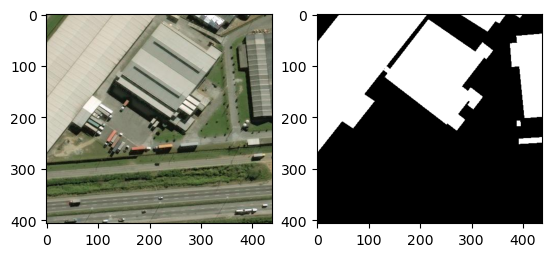

In [23]:
fig, ax =plt.subplots(1,2)
ax[0].imshow(load_img(os.path.join(rasterdir,inputPaths[300])))
ax[1].imshow(load_img(os.path.join(maskdir,labelPaths[300])))


Using a 70:15:15 split for Train, Test and Validation

In [24]:
num_train = int(len(labelPaths)*0.70) # 70:15:15 ; train, test, validation
num_test = int(len(labelPaths)*0.15)

In [130]:
# #Train, Test and Validation Splits

# train_x = input_imgss[:num_train]
# train_y = label_imgss[:num_train]
# val_x = input_imgss[-num_test:]
# val_y = label_imgss[-num_test:]
# test_x = input_imgss[-(num_test*2):-num_test]
# test_y = label_imgss[-(num_test*2):-num_test]

In [25]:
#Train, Test and Validation Splits - Low Res

train_x_lr = input_imgss_lr[:num_train]
train_y_lr = label_imgss_lr[:num_train]
val_x_lr = input_imgss_lr[-num_test:]
val_y_lr = label_imgss_lr[-num_test:]
test_x_lr = input_imgss_lr[-(num_test*2):-num_test]
test_y_lr = label_imgss_lr[-(num_test*2):-num_test]

In [26]:
train_y_lr.shape

(4858, 200, 200, 1)

Model Definition  
[Reference : DLP 2nd edition: Chapter 9]

In [27]:
from tensorflow.keras import layers
from tensorflow import keras

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size+(3,))
    x = layers.Rescaling(scale = 1./255) (inputs)

    x = layers.Conv2D(64,3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2D(64,3, activation="relu", padding="same") (x)
    x = layers.Conv2D(128,3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2D(128,3, activation="relu", padding="same") (x)    
    x = layers.Conv2D(256,3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2D(256,3, activation="relu", padding="same") (x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2) (x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2) (x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2) (x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same") (x)

    model = keras.Model(inputs, outputs)
    return model  

model_lr = get_model(img_size=img_size_lr,num_classes=2)
model_lr.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 256)       2951

Model Compilation and fitting 

In [28]:
model_lr.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [

    keras.callbacks.ModelCheckpoint("oxford_segmentation.karas",
                                    save_best_only=True)
]

In [29]:
history = model_lr.fit(train_x_lr,train_y_lr,
                    epochs=50, # 50
                    callbacks=callbacks,
                    batch_size=30   ,  #64
                    validation_data = (val_x_lr,val_y_lr))


Epoch 1/50
162/162 [==============================] - ETA: 0s - loss: 0.2844

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 789s 5s/step - loss: 0.2844 - val_loss: 0.2098
Epoch 2/50
162/162 [==============================] - ETA: 0s - loss: 0.2071

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 782s 5s/step - loss: 0.2071 - val_loss: 0.1944
Epoch 3/50
162/162 [==============================] - 740s 5s/step - loss: 0.1956 - val_loss: 0.2068
Epoch 4/50
162/162 [==============================] - ETA: 0s - loss: 0.1867

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 720s 4s/step - loss: 0.1867 - val_loss: 0.1812
Epoch 5/50
162/162 [==============================] - ETA: 0s - loss: 0.1801

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 723s 4s/step - loss: 0.1801 - val_loss: 0.1721
Epoch 6/50
162/162 [==============================] - ETA: 0s - loss: 0.1765

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 723s 4s/step - loss: 0.1765 - val_loss: 0.1699
Epoch 7/50
162/162 [==============================] - ETA: 0s - loss: 0.1706

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 724s 4s/step - loss: 0.1706 - val_loss: 0.1640
Epoch 8/50
162/162 [==============================] - ETA: 0s - loss: 0.1663

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 726s 4s/step - loss: 0.1663 - val_loss: 0.1579
Epoch 9/50
162/162 [==============================] - 721s 4s/step - loss: 0.1638 - val_loss: 0.1587
Epoch 10/50
162/162 [==============================] - ETA: 0s - loss: 0.1603

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 725s 4s/step - loss: 0.1603 - val_loss: 0.1540
Epoch 11/50
162/162 [==============================] - 720s 4s/step - loss: 0.1567 - val_loss: 0.1575
Epoch 12/50
162/162 [==============================] - ETA: 0s - loss: 0.1522

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 722s 4s/step - loss: 0.1522 - val_loss: 0.1494
Epoch 13/50
162/162 [==============================] - 720s 4s/step - loss: 0.1494 - val_loss: 0.1507
Epoch 14/50
162/162 [==============================] - ETA: 0s - loss: 0.1476

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 721s 4s/step - loss: 0.1476 - val_loss: 0.1415
Epoch 15/50
162/162 [==============================] - 724s 4s/step - loss: 0.1422 - val_loss: 0.1420
Epoch 16/50
162/162 [==============================] - 722s 4s/step - loss: 0.1417 - val_loss: 0.1432
Epoch 17/50
162/162 [==============================] - 722s 4s/step - loss: 0.1376 - val_loss: 0.1618
Epoch 18/50
162/162 [==============================] - ETA: 0s - loss: 0.1353

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 723s 4s/step - loss: 0.1353 - val_loss: 0.1328
Epoch 19/50
162/162 [==============================] - 723s 4s/step - loss: 0.1325 - val_loss: 0.1419
Epoch 20/50
162/162 [==============================] - 723s 4s/step - loss: 0.1304 - val_loss: 0.1504
Epoch 21/50
162/162 [==============================] - 723s 4s/step - loss: 0.1292 - val_loss: 0.1339
Epoch 22/50
162/162 [==============================] - ETA: 0s - loss: 0.1263

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 724s 4s/step - loss: 0.1263 - val_loss: 0.1277
Epoch 23/50
162/162 [==============================] - 725s 4s/step - loss: 0.1252 - val_loss: 0.1822
Epoch 24/50
162/162 [==============================] - ETA: 0s - loss: 0.1237

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 726s 4s/step - loss: 0.1237 - val_loss: 0.1242
Epoch 25/50
162/162 [==============================] - 14851s 92s/step - loss: 0.1220 - val_loss: 0.1301
Epoch 26/50
162/162 [==============================] - 772s 5s/step - loss: 0.1215 - val_loss: 0.1261
Epoch 27/50
162/162 [==============================] - 763s 5s/step - loss: 0.1205 - val_loss: 0.1551
Epoch 28/50
162/162 [==============================] - 741s 5s/step - loss: 0.1199 - val_loss: 0.1381
Epoch 29/50
162/162 [==============================] - ETA: 0s - loss: 0.1186

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 712s 4s/step - loss: 0.1186 - val_loss: 0.1210
Epoch 30/50
162/162 [==============================] - 712s 4s/step - loss: 0.1178 - val_loss: 0.1361
Epoch 31/50
162/162 [==============================] - 711s 4s/step - loss: 0.1175 - val_loss: 0.1234
Epoch 32/50
162/162 [==============================] - 710s 4s/step - loss: 0.1146 - val_loss: 0.1380
Epoch 33/50
162/162 [==============================] - 711s 4s/step - loss: 0.1145 - val_loss: 0.1223
Epoch 34/50
162/162 [==============================] - 710s 4s/step - loss: 0.1135 - val_loss: 0.1609
Epoch 35/50
162/162 [==============================] - 711s 4s/step - loss: 0.1135 - val_loss: 0.1226
Epoch 36/50
162/162 [==============================] - ETA: 0s - loss: 0.1142

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 748s 5s/step - loss: 0.1142 - val_loss: 0.1204
Epoch 37/50
162/162 [==============================] - ETA: 0s - loss: 0.1123

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 750s 5s/step - loss: 0.1123 - val_loss: 0.1187
Epoch 38/50
162/162 [==============================] - 737s 5s/step - loss: 0.1126 - val_loss: 0.1199
Epoch 39/50
162/162 [==============================] - 708s 4s/step - loss: 0.1111 - val_loss: 0.1373
Epoch 40/50
162/162 [==============================] - 709s 4s/step - loss: 0.1110 - val_loss: 0.1188
Epoch 41/50
162/162 [==============================] - 742s 5s/step - loss: 0.1098 - val_loss: 0.1242
Epoch 42/50
162/162 [==============================] - ETA: 0s - loss: 0.1093

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 754s 5s/step - loss: 0.1093 - val_loss: 0.1162
Epoch 43/50
162/162 [==============================] - 755s 5s/step - loss: 0.1079 - val_loss: 0.1167
Epoch 44/50
162/162 [==============================] - 746s 5s/step - loss: 0.1092 - val_loss: 0.1331
Epoch 45/50
162/162 [==============================] - ETA: 0s - loss: 0.1066

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 747s 5s/step - loss: 0.1066 - val_loss: 0.1159
Epoch 46/50
162/162 [==============================] - ETA: 0s - loss: 0.1067

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 753s 5s/step - loss: 0.1067 - val_loss: 0.1158
Epoch 47/50
162/162 [==============================] - 722s 4s/step - loss: 0.1060 - val_loss: 0.1463
Epoch 48/50
162/162 [==============================] - 718s 4s/step - loss: 0.1050 - val_loss: 0.1174
Epoch 49/50
162/162 [==============================] - 717s 4s/step - loss: 0.1041 - val_loss: 0.1221
Epoch 50/50
162/162 [==============================] - 718s 4s/step - loss: 0.1040 - val_loss: 0.1191


In [30]:
model_lr.save("model_lowres")

INFO:tensorflow:Assets written to: model_lowres\assets


INFO:tensorflow:Assets written to: model_lowres\assets


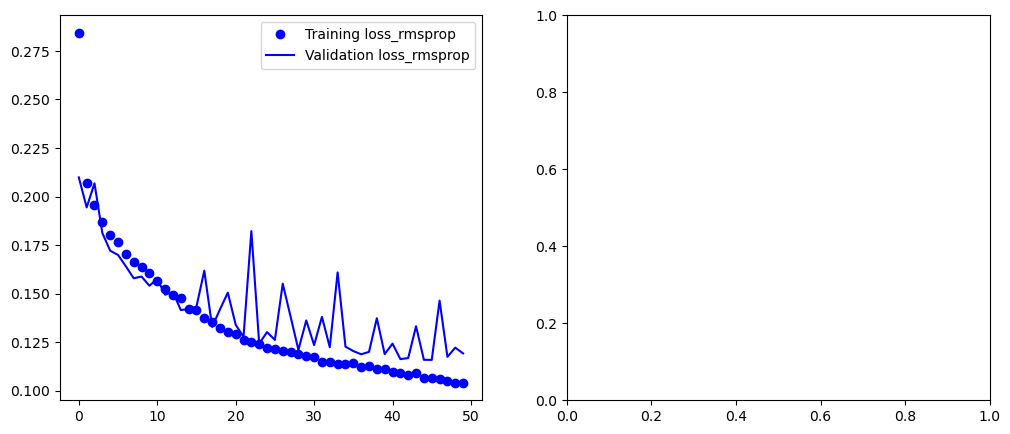

In [31]:
xa = range(len(history.epoch))
fig, ax =plt.subplots(1,2, figsize=(12,5))
ax[0].plot(xa,history.history['loss'],'bo', label='Training loss_rmsprop')
ax[0].plot(xa,history.history['val_loss'],'b', label='Validation loss_rmsprop')
ax[0].legend()

1/1 [==============================] - 0s 269ms/step


Text(0.5, 1.0, 'Deep Learning Output')

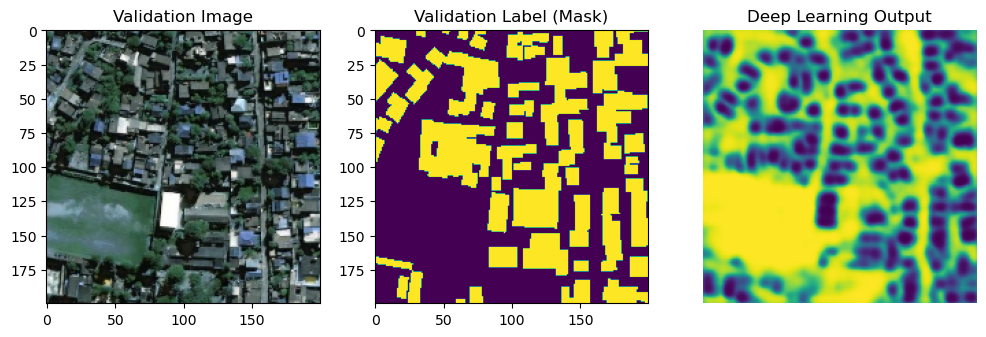

In [32]:
from tensorflow.keras.utils import array_to_img

i=626
test_i = val_x_lr[i]

mask = model_lr.predict(np.expand_dims(test_i,0)) [0]

fig, ax =plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(array_to_img(test_i))
def display_maska(pred,i):
    # pred = np.argmax(pred,axis=-1)
    # pred.reshape(200,200,1)
    pred *= 127
    plt.axis("off")
    ax[i].imshow(pred[:,:,0])

display_maska(mask,2)
display_maska(val_y_lr[i],1)
ax[0].set_title("Validation Image")
ax[1].set_title("Validation Label (Mask)")
ax[2].set_title("Deep Learning Output")


### Project Output Results and Shortcomings  

Output of the model sucessfully represents a low resolution identification of building region, owing to the limitation in compute power bigger convolution layers were unable to be tested.  
This type of segmentation is ideally achieved using the Unet convolution neural network, which was outside the scope of this course work. The work on this project will continue to implemnt a Unet styled implemntation in Keras.